In [2]:
## first time series test
# append ../../ to make link to main repo work
import sys
sys.path.append('../../')

# import external packages
import numpy as np
import pandas as pd
import numba
from numba import vectorize
import glob # for file search
import copy
import os # operating system stuff
import re # regex


import geopandas as gpd
import rasterio as rio
import rasterio.mask
from rasterio.plot import plotting_extent
from shapely.geometry import Polygon
from shapely.geometry.point import Point
import pyproj
from pyproj import CRS
from inpoly import inpoly2 # for fast inpolygon checks
import utm

import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
from matplotlib import cm as mpl_cm
from matplotlib import colors as mcolors 
import matplotlib.image as mplimg

from mpl_toolkits.axes_grid1 import make_axes_locatable # for colorbar scaling
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FormatStrFormatter

import seaborn as sns
from matplotlib import rc_file_defaults
rc_file_defaults()
# sns.set(style=None, color_codes=True)

from shapely.geometry import Polygon
from shapely.geometry.point import Point
import datetime

import configparser

from cmcrameri import cm # for scientific colourmaps

###########################
# import main local package
import SPOTSAR_main as sm


In [3]:
## estimate true EDM reflector position

# steps:

# 1: Load DEM data
# 2: load EDM data
# 3: determine distance of DEM to pos badaban
# 4: find minimum dist_DEM-EDM 
# 5: Plot results

In [4]:
# load EDM positions

### get EDM positions
pos_bad = np.array([110.410626, -7.526175, 1276])
reflectors = np.array(
    [[110.439757, -7.537567, 2407], [110.440165, -7.537451, 2425], [110.439260, -7.537533, 2360]]
)



In [5]:

# DEM
Merapi_DEM_file = "/Users/tz20896/Documents/PhD/projects/Merapi2021/geo/TDX_Merapi_WGS84_5m.tif"
with rio.open(Merapi_DEM_file) as img:
    DEM = img.read(1,masked=True) # rasterio bands are indexed from 1
    # extract DEM extent
    DEM_extent=[img.bounds.left,img.bounds.right,img.bounds.bottom,img.bounds.top]
    print('Band1 has shape', DEM.shape)
    height = DEM.shape[0]
    width  = DEM.shape[1]
    cols, rows = np.meshgrid(np.arange(width), np.arange(height))
    xs, ys = rio.transform.xy(img.transform, rows, cols)
    lons_DEM = np.array(xs)
    lats_DEM = np.array(ys)


# DEM
Merapi_HS_file = "/Users/tz20896/Documents/PhD/projects/Merapi2021/geo/TDX_Merapi_WGS84_HS.tif"
with rio.open(Merapi_HS_file) as img:
    SHADING = img.read(1,masked=True) # rasterio bands are indexed from 1




# lava flow files:
L1888_FILE  = '/Users/tz20896/Documents/PhD/projects/Merapi2021/merapi_maps/L1888_v2.shp'
L1948_FILE  = '/Users/tz20896/Documents/PhD/projects/Merapi2021/merapi_maps/L1948.shp'
L1956_FILE  = '/Users/tz20896/Documents/PhD/projects/Merapi2021/merapi_maps/L1956.shp'
L1992_FILE  = '/Users/tz20896/Documents/PhD/projects/Merapi2021/merapi_maps/L1992.shp'
L1997_FILE  = '/Users/tz20896/Documents/PhD/projects/Merapi2021/merapi_maps/L1997.shp'
L1998_FILE  = '/Users/tz20896/Documents/PhD/projects/Merapi2021/merapi_maps/L1998.shp'
CRATER_FILE = '/Users/tz20896/Documents/PhD/projects/Merapi2021/merapi_maps/Merapi_crater.shp'

# Read the shapefile
L1888  = gpd.read_file(L1888_FILE)
L1948  = gpd.read_file(L1948_FILE)
L1956  = gpd.read_file(L1956_FILE)
L1992  = gpd.read_file(L1992_FILE)
L1997  = gpd.read_file(L1997_FILE)
L1998  = gpd.read_file(L1998_FILE)
CRATER = gpd.read_file(CRATER_FILE)

# Extract latitude and longitude into separate columns
coords_L1888   = np.array(list(L1888 ["geometry"][0].coords))
coords_L1956_1 = np.array(list(L1956 ["geometry"][0].coords))
coords_L1956_2 = np.array(list(L1956 ["geometry"][1].coords))
coords_L1948   = np.array(list(L1948 ["geometry"][0].coords))
coords_L1992   = np.array(list(L1992 ["geometry"][0].coords))
coords_L1997   = np.array(list(L1997 ["geometry"][0].coords))
coords_L1998   = np.array(list(L1998 ["geometry"][0].coords))
coords_CRATER  = np.array(list(CRATER["geometry"][0].coords))

Band1 has shape (2028, 1672)


/var/folders/7b/9xvft5dd0455jpkm_r7rgr3w0000gp/T/ipykernel_57830/1829824272.py:8: RuntimeWarning: invalid value encountered in sqrt
  DEM_dist = np.sqrt(DEM_local_x**2+DEM_local_y**2+DEM_local_z**2)


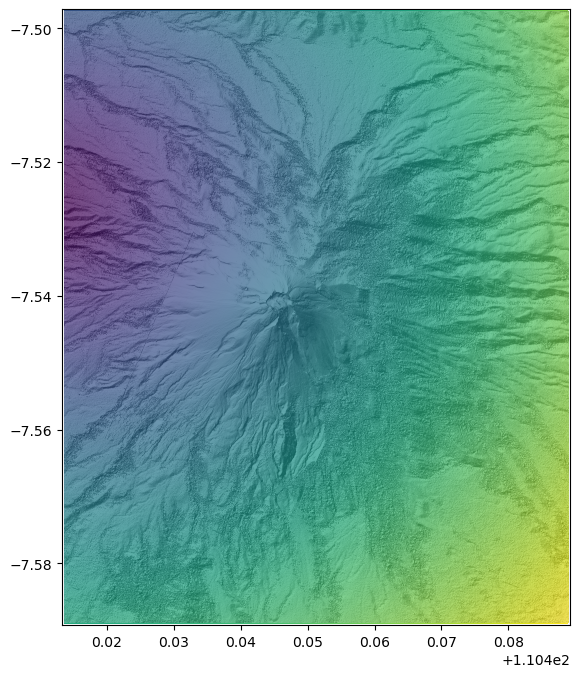

In [11]:
import pymap3d as pm



# DEM_local_x, DEM_local_y, DEM_local_z = pm.geodetic2enu(lats_DEM.ravel(), lons_DEM.ravel(), DEM.ravel(), pos_bad[1], pos_bad[0], pos_bad[2])
DEM_local_x, DEM_local_y, DEM_local_z = pm.geodetic2enu(lats_DEM, lons_DEM, DEM, pos_bad[1], pos_bad[0], pos_bad[2])

DEM_dist = np.sqrt(DEM_local_x**2+DEM_local_y**2+DEM_local_z**2)



In [27]:
%matplotlib osx


import matplotlib.patches as mpatches
import matplotlib.transforms as mtransforms
def add_bottom_cax(ax, pad, height):
    axpos = ax.get_position()
    caxpos = mtransforms.Bbox.from_extents(
        axpos.x0,
        axpos.y0 - pad - height,
        axpos.x1,
        axpos.y0 - pad
    )
    cax = ax.figure.add_axes(caxpos)

    return cax

lon_lims = [110.432, 110.45]
lat_lims = [-7.547, -7.535]
EDM_start = [4044.837, 3859.1115]
vmax = 10
fig, ax = plt.subplots(1,2,figsize=(8,8))
dist_data = ax[0].imshow(DEM_dist-EDM_start[0],extent=DEM_extent,cmap=cm.vik, vmin=-vmax, vmax=vmax)
ax[0].imshow(SHADING,extent=DEM_extent,alpha=0.3,cmap='Greys_r')
ax[0].scatter(x=reflectors[:,0],y=reflectors[:,1],s=10,marker='v',color='tab:orange', label='EDM reflectors')
ax[0].scatter(x=reflectors[0,0],y=reflectors[0,1],s=10,marker='v',color='tab:red', label='RB1')
ax[0].set_xlim(lon_lims)
ax[0].set_ylim(lat_lims)
cax = add_bottom_cax(ax[0], 0.2, 0.02)
plt.colorbar(dist_data,cax=cax, label='distance to RB1 - 4044.837 m', orientation = 'horizontal', location='bottom',extend='both')
ax[0].legend()

dist_data = ax[1].imshow(DEM_dist-EDM_start[1],extent=DEM_extent,cmap=cm.vik,vmin=-vmax, vmax=vmax)
ax[1].imshow(SHADING,extent=DEM_extent,alpha=0.3,cmap='Greys_r')
ax[1].scatter(x=reflectors[:,0],y=reflectors[:,1],s=10,marker='v',color='tab:orange', label='EDM reflectors')
ax[1].scatter(x=reflectors[1,0],y=reflectors[1,1],s=10,marker='v',color='tab:red', label='RB2')
ax[1].set_xlim(lon_lims)
ax[1].set_ylim(lat_lims)
cax = add_bottom_cax(ax[1], 0.2, 0.02)
plt.colorbar(dist_data,cax=cax,label='distance to RB2 - 3859.1115 m', orientation = 'horizontal', location='bottom',extend='both')
ax[1].legend()